In [1]:
# Imports the required packages for our analyses
import numpy as np
import scipy as sp
import scipy.io as SPO
from matplotlib import pyplot as plt
import pandas as pd
from numpy.linalg import inv

In [5]:
# plotting settings
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
# Functional activation over time
B = SPO.loadmat('../Data/RS_Imaging/Data1_LR.mat');
C = SPO.loadmat('../Data/RS_Imaging/Data1_RL.mat');

Data1 = B['Data1_LR'];
Data2 = C['Data1_RL'];

In [3]:
# Structural connectivity
A = SPO.loadmat('../Data/Structural_Data/A_Glasser.mat');
Adj = A['A_Glasser'];

In [4]:
# Behavioral variables
D = SPO.loadmat('../Data/Behavioral_Data/Fluid.mat');
E = SPO.loadmat('../Data/Behavioral_Data/Crystal.mat');
F = SPO.loadmat('../Data/Behavioral_Data/Total.mat');

Fluid = D['Fluid'];
Crystal = E['Crystal'];
Total = F['Total'];

In [170]:
Data1.shape

(360, 1190, 100)

/home/apadee/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/apadee/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


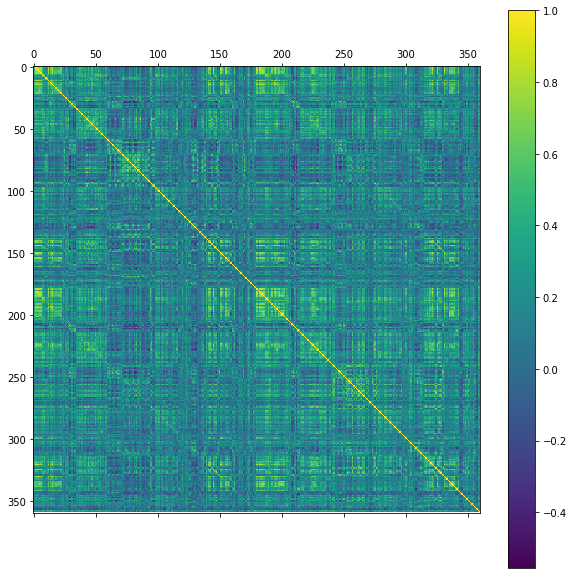

In [6]:
#autocorrelation between brain regions

cmatrix = np.zeros(Data1.shape[2],dtype=object)
for i in range(0,Data1.shape[2]):
    cmatrix[i] = np.corrcoef(Data1[:,:,i])

#cmatrix[0].shape
plt.matshow(cmatrix[5])
#plt.xticks(range(cmatrix[0].shape[0]))
#plt.yticks(range(cmatrix[0].shape[1]))
# plt.set_cmap('inferno')
plt.colorbar()
plt.show()

In [176]:
# 1. Dynamic mode decomposition

# Construction of the matrix of regressors and associated "output matrix"

# Dynamic modes and their eigenvalues will be stored in a list
Damp = np.zeros((100,360),dtype=np.complex_);
Period = np.zeros((100,360),dtype=np.complex_);
Modes = np.zeros((100,360,360),dtype=np.complex_);

# Loops across subjects
for i in range (0,100):
    
    # Samples time courses for the subject of interest
    X = Data1[:,:,i]; X = X[:,1:1190];
    Y = Data1[:,:,i]; Y = Y[:,0:1189];
    
    # Computes the solution of the regression
    A = np.matmul(np.matmul(X,Y.T),inv(np.matmul(Y+1e-10,Y.T+1e-10)));
    
    # Computes the dynamic modes (DM) and their eigenvalues (Lambda)
    Lambda,DM = np.linalg.eig(A);
    
    # Damping time and period for each mode
    
    for m in range (0,360):
        Damp[i,m] = -1/np.log(np.abs(Lambda[m]));
        
        if (np.abs(np.angle(Lambda[m])) == 0):
            Period[i,m] = 0;
        else:
            Period[i,m] = 2*np.pi/np.abs(np.angle(Lambda[m]));

        Modes[i,m,:] = DM[:,m];

# Damp and Period contain the damping time and period of the dynamic modes, while
# Modes contains the modes themselves




# Ideas for improved feature computations:
# - Tune the framework to derive population-level dynamic modes

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


In [177]:
# 2. Graph Signal Processing

# Construction of the Laplacian matrix from the adjacency
D = np.zeros((360,360));

for i in range (0,360):
    D[i,i] = np.sum(Adj[:,i]);

# For a start, let us use the standard definition of the Laplacian
L = D - Adj;

# Eigendecomposition of the Laplacian
Sigma,V = np.linalg.eig(L);

# Sorts the results to arange the eigenmodes in increasing level of frequency
IDX = np.argsort(Sigma);

Sigma = Sigma[IDX];
V = V[:,IDX];

C = np.zeros((100,1190,360));

# For each time point and each subject, we can now extract a measure of strength of expression along the building blocks
for s in range (0,100):
    for t in range (0,1190):
        
        # Projection on each of the building blocks
        tmp_data = Data1[:,t,s];
        
        for b in range (0,360):
            C[s,t,b] = np.dot(tmp_data,V[:,b]);

# C contains the coefficients depicting, for each of the 360 eigenmodes, how strongly it is expressed
# at a given time point in the data





# Ideas for improved feature computations:
# - Consider averaged values of expression strength across the building blocks with lowest/highest spatial frequency
# - Consider statistical testing by comparison to e.g., phase-randomized data, to assess significant excursions


In [ ]:
# TO ADD: LINK WITH BEHAVIOUR